In [39]:
import opendatasets as od
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime as dt
import numpy as np


import warnings
warnings.filterwarnings('ignore')

### 1. Violent incidents

#### Download the dataset from the Kaggle website

In [40]:
def create_file():
    try:
        if not os.path.exists('data'):
            od.download("https://www.kaggle.com/datasets/emmanuelfwerr/gun-violence-incidents-in-the-usa")
            os.rename(os.listdir()[0],'data')
            #os.remove('./data/mass_shootings.csv')
    except Exception as e:
        print('Failed to create or deleted')

create_file()

#### Rename the directory and the file as *data* and *violence* respectively

In [41]:
for (dirpath, dirnames, filenames) in os.walk('./'):
    for filename in filenames:
        if filename.endswith('.csv'):
            name_file = filename
            if name_file == 'all_incidents.csv':
                os.rename(dirpath + '/'+ filename, dirpath +'/'+'violence.csv')
                address = "".join(dirpath +'/'+'violence.csv')
            else:
                address = "".join(dirpath +'/'+'violence.csv')
           


#### Load the file *violence.csv* as a dataframe

In [42]:
try:
    df = (pd.read_csv(address)
          .set_index('incident_id')
        )
    print(f"Shape of DF: {df.shape}")
except  FileNotFoundError:
    print("Cannot open the file")


Shape of DF: (472820, 6)



### Find percent of null value per feature

In [43]:
df_null = pd.DataFrame(100*df.isnull().sum()/len(df), columns=['Percent_null'])
df_null['Percent_null'].sort_values(ascending=False)


address      5.019035
date         0.000000
state        0.000000
city         0.000000
n_killed     0.000000
n_injured    0.000000
Name: Percent_null, dtype: float64


#### Preprocesing the dataframe

In [44]:
columns = [col for col in df.columns if col != 'address']
df = df[columns]

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['state'] = df['state'].astype('string')
df['city'] = df['city'].astype('string')
df['year'] = df['date'].dt.strftime('%Y').astype('int')
df['month'] = df['date'].dt.strftime('%m').astype('int')
df['Total_Victims'] = df['n_injured'] + df['n_killed']
df['date'] = df['date'].dt.date

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472820 entries, 2314858 to 461105
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   date           472820 non-null  object
 1   state          472820 non-null  string
 2   city           472820 non-null  string
 3   n_killed       472820 non-null  int64 
 4   n_injured      472820 non-null  int64 
 5   year           472820 non-null  int32 
 6   month          472820 non-null  int32 
 7   Total_Victims  472820 non-null  int64 
dtypes: int32(2), int64(3), object(1), string(2)
memory usage: 28.9+ MB


In [45]:
df.head()

,date,state,city,n_killed,n_injured,year,month,Total_Victims
incident_id,,,,,,,,
2314858,2022-05-28,Arkansas,Little Rock,0,1,2022,5,1
2314409,2022-05-28,Colorado,Denver,0,1,2022,5,1
2314498,2022-05-28,Missouri,Saint Louis,0,1,2022,5,1
2314485,2022-05-28,South Carolina,Florence,0,2,2022,5,2
2314483,2022-05-28,California,Carmichael,1,0,2022,5,1


### Most violent year

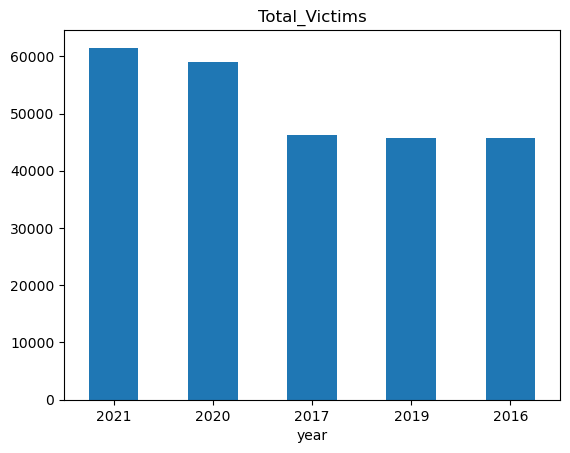

In [46]:
(df.groupby(['year'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .plot(kind='bar', title="Total_Victims", rot = 0)
)
plt.show()

#### Top five most violent states

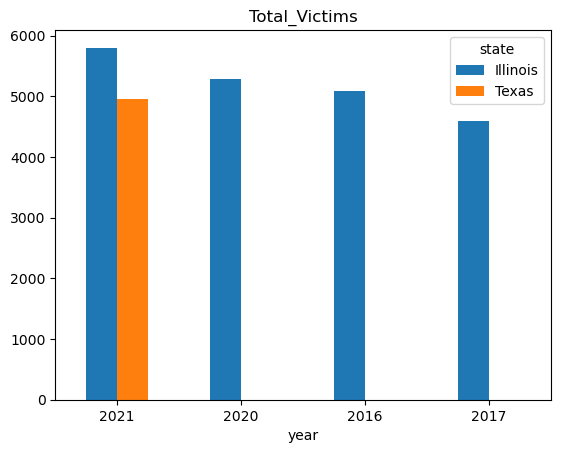

In [47]:
(df.groupby(['year','state'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .unstack(level=1)
 .plot(kind='bar', title="Total_Victims", rot = 0)
)
plt.show()

#### Top ten most violent months

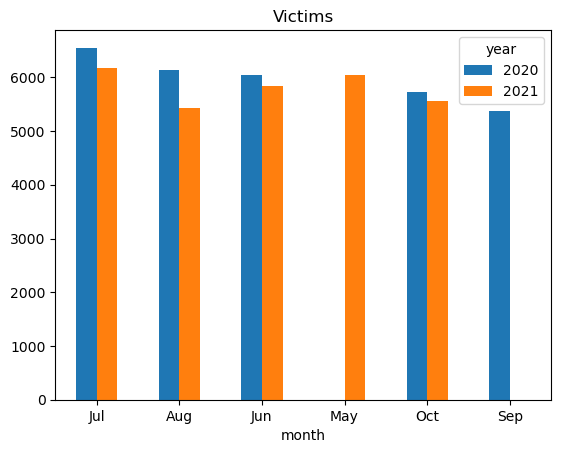

In [48]:
map_month = dict((index,month ) for index, month in enumerate(calendar.month_abbr) if month)

(df.replace({"month": map_month})
 .groupby(['year','month'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:10]
 .unstack(level=0)
 .plot(kind='bar', title="Victims", rot = 0)
)
plt.show()

#### Most violent day

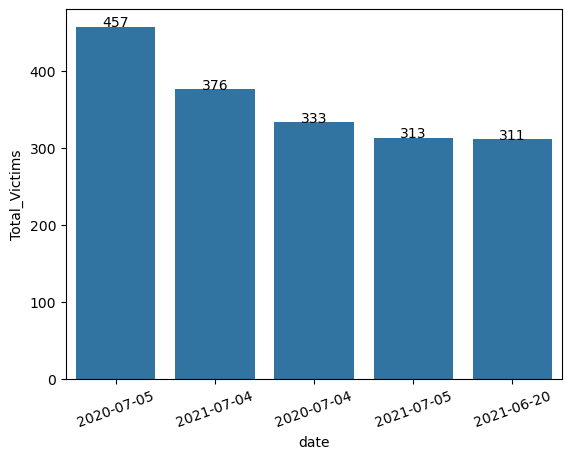

In [49]:
df_day = (df.groupby(['date'])['Total_Victims']
            .sum()
            .sort_values(ascending=False)[:5]
            .to_frame()
            .reset_index()

        )
ax = sns.barplot(data=df_day, x = 'date', y = 'Total_Victims')
ax.tick_params(axis='x', rotation=20)

for i, v in enumerate(df_day['Total_Victims']):
   ax.text(i, v + 0.2, str(v), ha='center')



From the previos Figure, we can conclude that dates related to the Independence Day present the most violent incidents

#### Most violence city per year

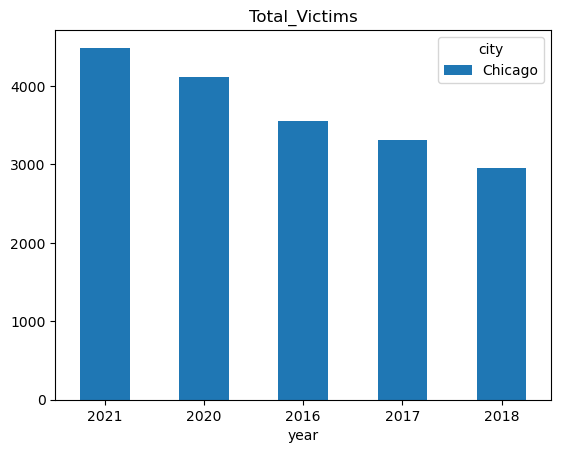

In [50]:
(df.groupby(['year','city'])['Total_Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .unstack(level=1)
 .plot(kind='bar', title="Total_Victims", rot=0)
)
plt.show()

#### Top state violent incidents per year

The most violent city is considered on basis of the number of incidents occurred in the city along a year

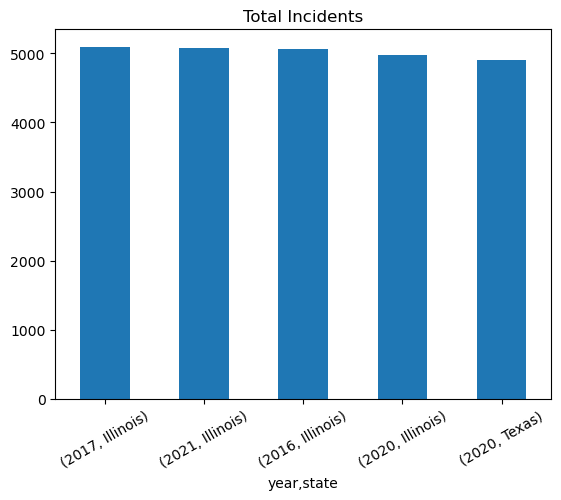

In [51]:
df_city = (df.groupby(['year','state'])['state']
            .count()
            .sort_values(ascending=False)[:5]
            .plot(kind='bar', title="Total Incidents", rot=30 )
          )

### 2. Mass shooting

In [52]:
try:
    df_mass = (pd.read_csv('./data/mass_shootings.csv')
                 .set_index('Incident ID')
                )
    print(f"Shape of DF: {df_mass.shape}")
except  FileNotFoundError:
    print("Cannot open the file")

Shape of DF: (3609, 6)


In [53]:
df_mass.rename(columns={"Incident Date":'date',
                        'City Or County':'City',
                         '# Killed': "killed",
                          '# Injured': 'injured'},
                inplace = True         
                )
columns = [col for col in df_mass.columns if col != 'Address']
df_mass = df_mass[columns]
df_mass['date'] = pd.to_datetime(df_mass['date'].astype('string'))
df_mass['City'] = df_mass['City'].astype('string')
df_mass['State'] = df_mass['State'].astype('string')  
df_mass['Victims'] = df_mass['killed'] + df_mass['injured'] 
df_mass['year'] = df_mass['date'].dt.year
df_mass['month'] = df_mass['date'].dt.month                              


In [54]:
df_mass.tail()

,date,State,City,killed,injured,Victims,year,month
Incident ID,,,,,,,,
274867,2015-01-06,Florida,Miami,1,3,4,2015,1
273535,2015-01-04,Virginia,Roanoke,2,4,6,2015,1
273397,2015-01-04,Texas,Dallas,3,1,4,2015,1
273965,2015-01-02,Georgia,Savannah,1,4,5,2015,1
272016,2015-01-01,Tennessee,Memphis,0,5,5,2015,1


#### City with the most violent mass shooting 

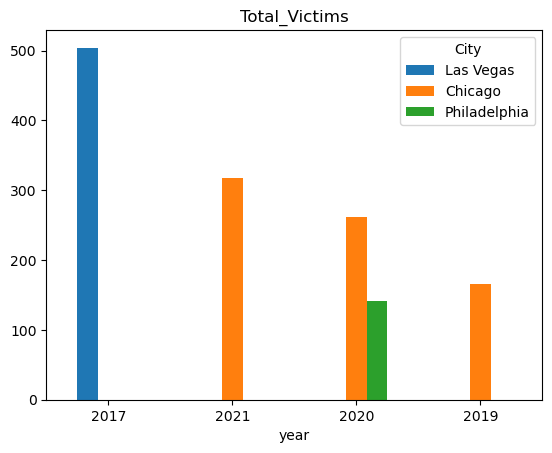

In [55]:
(df_mass.groupby(['year','City'])['Victims']
 .sum()
 .sort_values(ascending=False)[:5]
 .unstack(level=1)
 .plot(kind='bar', title="Total_Victims", rot=0)
)
plt.show()

#### Most violent day

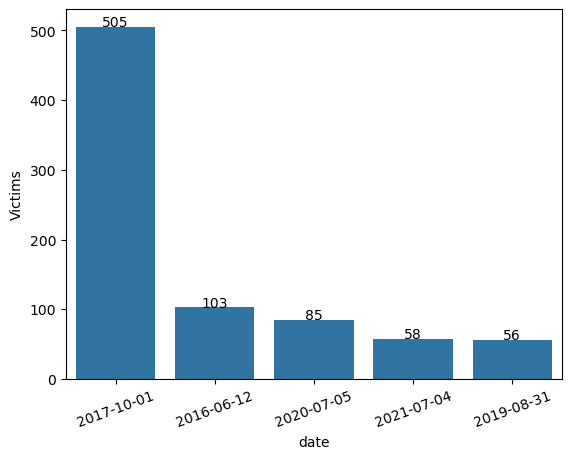

In [56]:
df_day = (df_mass.groupby(['date'])['Victims']
            .sum()
            .sort_values(ascending=False)[:5]
            .to_frame()
            .reset_index()

        )
ax = sns.barplot(data=df_day, x = 'date', y = 'Victims')
ax.tick_params(axis='x', rotation=20)

for i, v in enumerate(df_day['Victims']):
   ax.text(i, v + 0.2, str(v), ha='center')

The most violent day was October 1st in 2017 where, among other incidents, we can found the massacre in Las Vegas 

#### Top five states with the highest number of incidents per year 

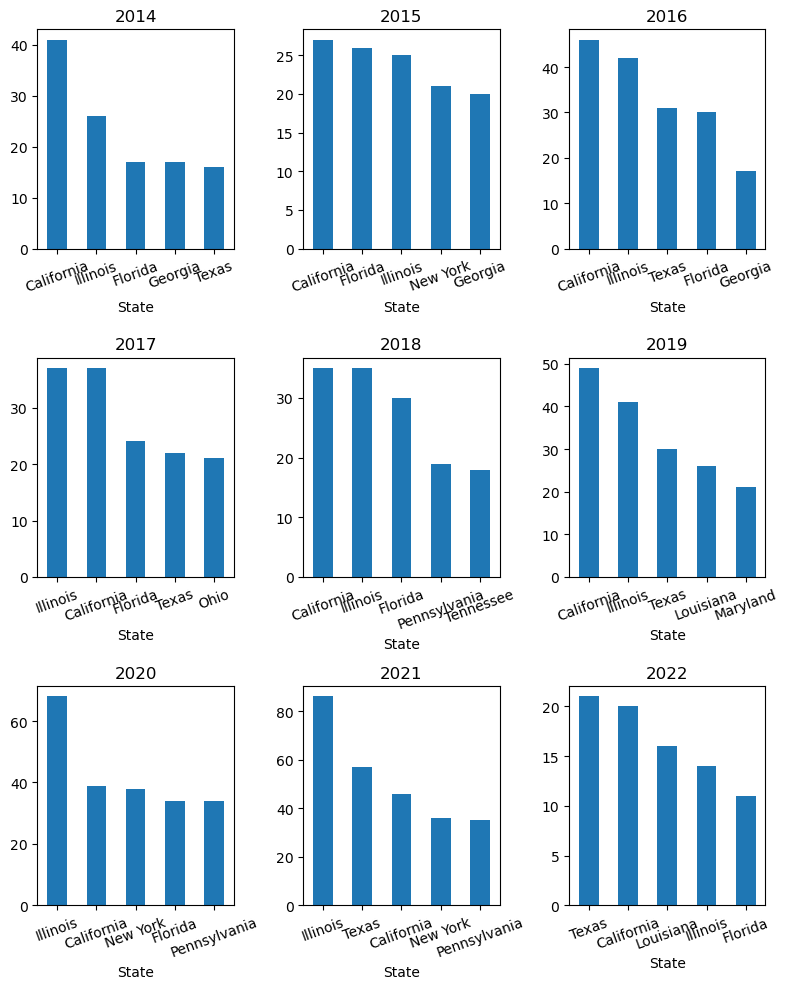

In [57]:
df_mass_state = (df_mass
                 .groupby(['year','State'])['State' ]
                .agg('count')
                .rename({'State': 'Incidents'})
                .unstack(level=0)
                .fillna(value=0)
                                            
                )

fig, axes = plt.subplots(3,3, figsize=(8,10))
columns = np.reshape(df_mass_state.columns,(-1,3))

for i in range(3):
    for j in range(3):
         (df_mass_state[columns[i,j]]
            .sort_values(ascending=False)
            .iloc[:5]
            .plot(kind='bar', rot=20,ax = axes[i,j], title = str(columns[i,j]))  
         )
    
fig.tight_layout()

   